In [7]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [8]:
# 添加安全除法函数
def safe_divide(a, b, default=0):
    """安全除法，避免除以0和无穷大"""
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.divide(a, b)
        result = np.where(np.isfinite(result), result, default)
    return result

In [9]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [10]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [11]:
def train_imbalance_model(df, window=100, lookback_periods=10, test_size=0.2):
    """
    训练不平衡值预测模型
    """
    # 准备特征工程
    df_feat = df.copy()
    
    # 1. 计算历史不平衡值（标签）
    df_feat['period_return'] = safe_divide((df_feat['close'] - df_feat['open']), df_feat['open'])
    hist_returns = df_feat['period_return'].shift(1)
    
    returns_matrix = pd.DataFrame()
    for i in range(1, lookback_periods + 1):
        returns_matrix[f't-{i}'] = hist_returns.shift(i - 1)
    
    def calc_imbalance(row):
        pos_returns = row[row > 0]
        neg_returns = row[row < 0]
        avg_pos = pos_returns.mean() if len(pos_returns) > 0 else 0
        avg_neg = abs(neg_returns.mean()) if len(neg_returns) > 0 else 0
        return avg_pos - avg_neg
    
    df_feat['hist_imbalance'] = returns_matrix.apply(calc_imbalance, axis=1)
    
    # 2. 特征工程
    # 基本量价特征
    df_feat['price_change'] = df_feat['close'].pct_change()
    df_feat['volatility'] = safe_divide((df_feat['high'] - df_feat['low']), df_feat['open'])
    
    # 安全计算body_ratio
    high_low_diff = df_feat['high'] - df_feat['low']
    high_low_diff = np.where(high_low_diff == 0, 1e-6, high_low_diff)
    df_feat['body_ratio'] = abs(df_feat['close'] - df_feat['open']) / high_low_diff
    
    # 成交量相关特征
    df_feat['volume_pct_change'] = df_feat['volume'].pct_change()
    
    # 安全计算volume_z
    volume_mean = df_feat['volume'].rolling(window, min_periods=1).mean()
    volume_std = df_feat['volume'].rolling(window, min_periods=1).std()
    volume_std = np.where(volume_std == 0, 1e-6, volume_std)
    df_feat['volume_z'] = safe_divide((df_feat['volume'] - volume_mean), volume_std)
    
    # 技术指标特征
    df_feat['ma5'] = df_feat['close'].rolling(5, min_periods=1).mean()
    df_feat['ma20'] = df_feat['close'].rolling(20, min_periods=1).mean()
    
    # 安全计算RSI
    delta = df_feat['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14, min_periods=1).mean()
    avg_loss = loss.rolling(14, min_periods=1).mean()
    rs = safe_divide(avg_gain, avg_loss, default=1)
    df_feat['rsi'] = 100 - (100 / (1 + rs))
    
    # 滞后特征
    for lag in [1, 2, 3, 5]:
        df_feat[f'imbalance_lag{lag}'] = df_feat['hist_imbalance'].shift(lag)
        df_feat[f'volatility_lag{lag}'] = df_feat['volatility'].shift(lag)
    
    # 3. 准备数据集
    features = df_feat[['volume_z', 'volatility', 'body_ratio', 'price_change', 
                       'volume_pct_change', 'ma5', 'ma20', 'rsi',
                       'imbalance_lag1', 'imbalance_lag2', 'imbalance_lag3',
                       'volatility_lag1', 'volatility_lag2']]
    
    labels = df_feat['hist_imbalance']
    
    # 替换无穷大和NaN
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(0)
    labels = labels.replace([np.inf, -np.inf], np.nan)
    labels = labels.fillna(0)
    
    # 删除NaN值
    valid_idx = features.dropna().index.intersection(labels.dropna().index)
    features = features.loc[valid_idx]
    labels = labels.loc[valid_idx]
    
    # 4. 时间序列分割
    tscv = TimeSeriesSplit(n_splits=5)
    best_model = None
    best_score = float('inf')
    
    for train_index, test_index in tscv.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        
        # 训练模型
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=7,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # 评估模型
        preds = model.predict(X_test)
        score = mean_squared_error(y_test, preds)
        
        if score < best_score:
            best_score = score
            best_model = model
    
    print(f"最佳模型MSE: {best_score:.6f}")
    return best_model, features.columns

In [12]:
def predicted_imbalance_factor(df, model=None, feature_columns=None):
    """
    使用训练好的模型预测不平衡值
    """
    # 首次调用时训练模型
    if model is None or feature_columns is None:
        model, feature_columns = train_imbalance_model(df)
    
    # 实时特征生成
    df_feat = df.copy()
    
    # 计算所有特征
    window = 100
    lookback_periods = 10
    
    # 基本量价特征
    df_feat['price_change'] = df_feat['close'].pct_change()
    df_feat['volatility'] = safe_divide((df_feat['high'] - df_feat['low']), df_feat['open'])
    
    # 安全计算body_ratio
    high_low_diff = df_feat['high'] - df_feat['low']
    high_low_diff = np.where(high_low_diff == 0, 1e-6, high_low_diff)
    df_feat['body_ratio'] = abs(df_feat['close'] - df_feat['open']) / high_low_diff
    
    # 成交量相关特征
    df_feat['volume_pct_change'] = df_feat['volume'].pct_change()
    
    # 安全计算volume_z
    volume_mean = df_feat['volume'].rolling(window, min_periods=1).mean()
    volume_std = df_feat['volume'].rolling(window, min_periods=1).std()
    volume_std = np.where(volume_std == 0, 1e-6, volume_std)
    df_feat['volume_z'] = safe_divide((df_feat['volume'] - volume_mean), volume_std)
    
    # 技术指标特征
    df_feat['ma5'] = df_feat['close'].rolling(5, min_periods=1).mean()
    df_feat['ma20'] = df_feat['close'].rolling(20, min_periods=1).mean()
    
    # 安全计算RSI
    delta = df_feat['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14, min_periods=1).mean()
    avg_loss = loss.rolling(14, min_periods=1).mean()
    rs = safe_divide(avg_gain, avg_loss, default=1)
    df_feat['rsi'] = 100 - (100 / (1 + rs))
    
    # 滞后特征
    df_feat['imbalance_lag1'] = df_feat.get('hist_imbalance', pd.Series(0, index=df_feat.index)).shift(1)
    df_feat['imbalance_lag2'] = df_feat.get('hist_imbalance', pd.Series(0, index=df_feat.index)).shift(2)
    df_feat['imbalance_lag3'] = df_feat.get('hist_imbalance', pd.Series(0, index=df_feat.index)).shift(3)
    df_feat['volatility_lag1'] = df_feat['volatility'].shift(1)
    df_feat['volatility_lag2'] = df_feat['volatility'].shift(2)
    
    # 异常信号
    volume_mean = df_feat['volume'].rolling(window, min_periods=1).mean()
    volume_std = df_feat['volume'].rolling(window, min_periods=1).std()
    volume_std = np.where(volume_std == 0, 1e-6, volume_std)
    df_feat['is_abnormal'] = (df_feat['volume'] > (volume_mean + 1.0 * volume_std)).astype(int)
    
    # 选择模型需要的特征
    current_features = df_feat[feature_columns]
    
    # 替换无穷大和NaN
    current_features = current_features.replace([np.inf, -np.inf], np.nan)
    current_features = current_features.fillna(0)
    
    # 预测不平衡值
    predicted_imbalance = model.predict(current_features)
    
    # 创建结果序列
    result = pd.Series(np.nan, index=df.index)
    valid_idx = current_features.index
    result.loc[valid_idx] = predicted_imbalance
    
    # 应用异常信号
    result = df_feat['is_abnormal'] * result
    
    return result

# 测试因子表现

In [13]:
# 预先训练模型
model, feature_columns = train_imbalance_model(df)

# 创建因子计算函数（包装器）
def predicted_factor_wrapper(df):
    return predicted_imbalance_factor(df, model, feature_columns)

最佳模型MSE: 0.000000



📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.014527
   Rank_IC (Spearman): -0.014112
📊 信息比率:
   IR: -0.478923
   有效分组数: 2
📊 因子分布:
📋 数据概况:
   数据长度: 131035
   因子列: predicted_imbalance
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


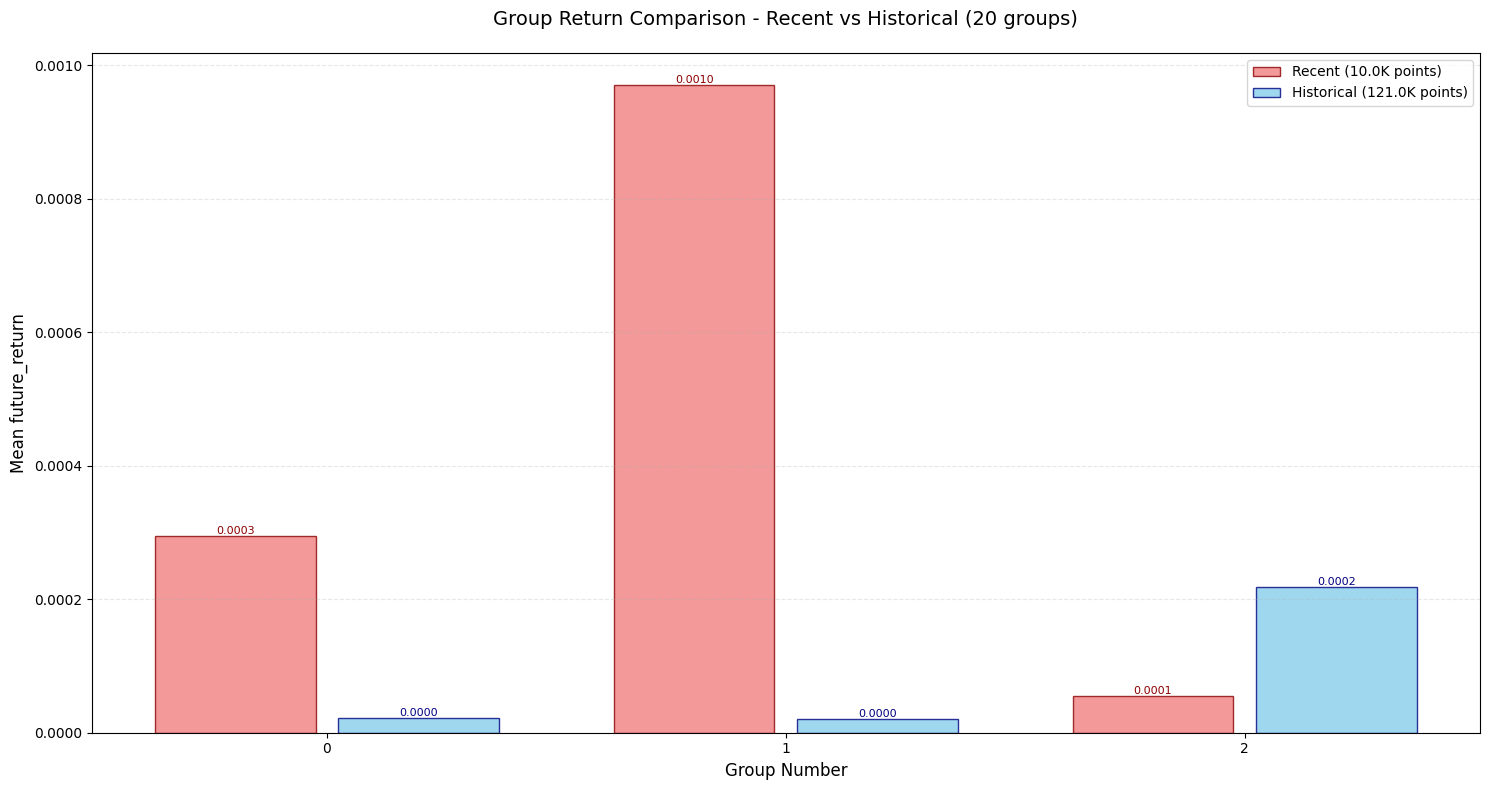

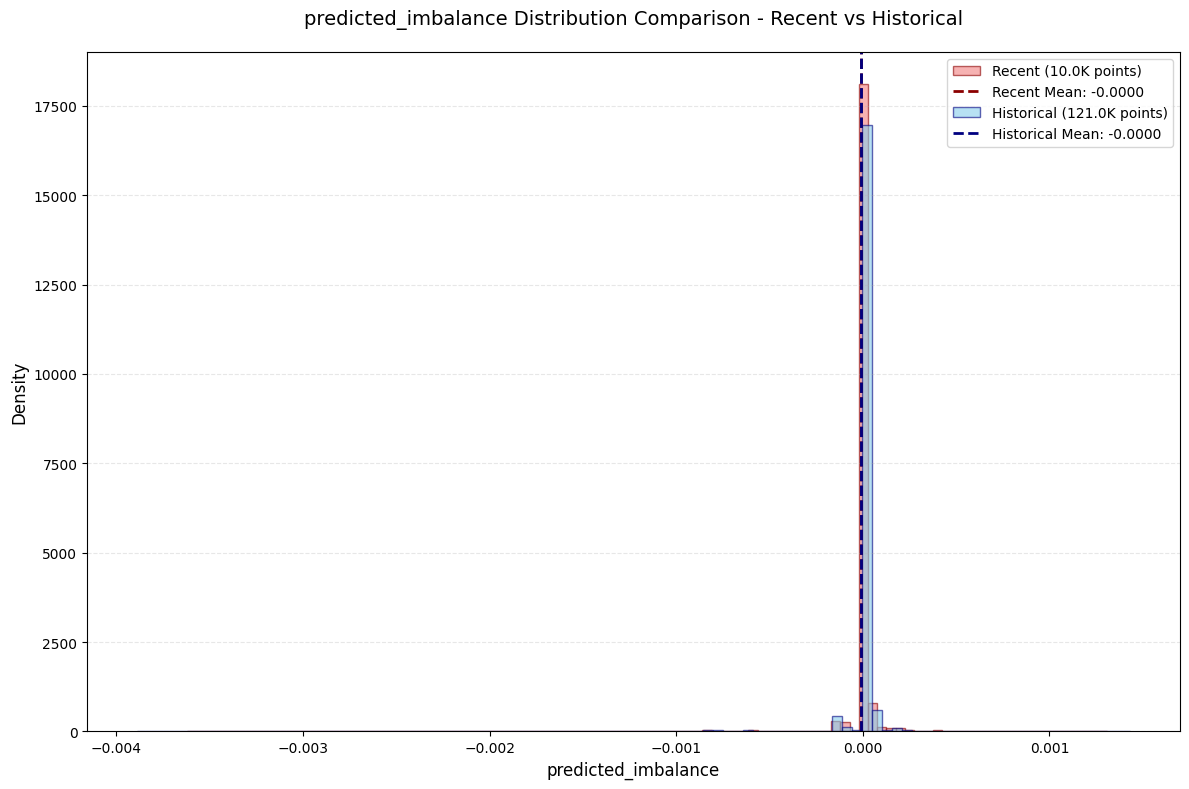

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [14]:
evaluator.set_factor(
    factor_func=predicted_factor_wrapper,
    factor_name='predicted_imbalance'
)

result_predicted = evaluator.run_full_evaluation(run_stationarity_test=False)

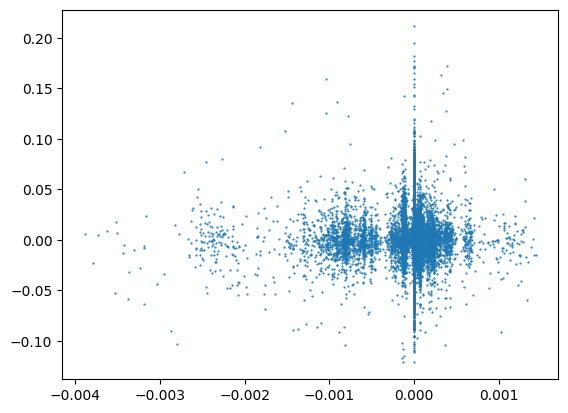

In [15]:
import matplotlib.pyplot as plt
plt.scatter(predicted_factor_wrapper(df),df['close'].pct_change(-10), s=0.3)

In [16]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

NameError: name 'result' is not defined

In [17]:
print(result)

NameError: name 'result' is not defined